In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

C:\Users\malce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Building The Network

In [2]:
class Network(nn.Module):
  # define network structure
  def __init__(self):
    super(Network, self).__init__()
    self.dropout = nn.Dropout(0.2)
    self.lin1 = nn.Linear(200,64)
    self.lin2 = nn.Linear(64,32)
    self.lin3 = nn.Linear(32,4)

  # define forward function
  def forward(self, x):   
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.dropout(x) 
    x = F.sigmoid(self.lin3(x))
    return x

In [3]:
# define training function
def train(net, dataset, optimizer):
  net.train()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = Variable(target).cuda()
    criterion = nn.MSELoss() # define loss function 
    loss = criterion(output, target)
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print( "train loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

In [4]:
# define testing function
def test(net, dataset):
  net.eval()
  total_loss = 0
  for input, target in dataset:
    input = Variable(input).cuda()
    output = net(input)
    target = target.cuda()
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    total_loss += loss.item()
  print("test loss:", (total_loss/len(dataset)))
  return (total_loss/len(dataset))

Loading the data

In [5]:
input = pd.read_table("../data/training/train_data_RNA_200.txt", sep = " ", header=0)
labels = pd.read_csv("../data/pre_processed/RNA_annotations.csv")
codes, uniques = labels["Sub_trajectory_name"].factorize() # transform labels into factors

In [7]:
# creat custom dataset class
class Custom_Dataset(Dataset):
    def __init__(self, input, labels):
        dist_labels = torch.Tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
        self.X = [torch.Tensor(row.tolist()) for indx, row in input.iterrows()]
        self.y = [dist_labels[label] for label in labels]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [8]:
data = Custom_Dataset(input, codes)

# indices = np.random.choice(len(data), 17278, replace=False) # create subset for comparison to scATAC-Seq data

# data = Subset(data, indices)

train_dataset, test_dataset = random_split(data, [0.7, 0.3]) # 70/30 train/test split

data_loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=64, shuffle=True)

Training

In [14]:
net = Network()
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.001) # define optimizer
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,30,70], gamma=0.1) # create LR sceduler

train_loss = []
test_loss = []

# perform 100 training epochs
for epoch in range(100):
  print("epoch:", epoch+1)
  tr_loss = train(net, data_loader_train, optimizer)
  te_loss = test(net, data_loader_test)
  train_loss.append(tr_loss)
  test_loss.append(te_loss)
  scheduler.step()

np.savez('learning_curves/Learning_Curves_RNA.npz', train_loss=train_loss, test_loss=test_loss)
torch.save(net, 'trained_networks/saved_net_RNA.py')

epoch: 1
train loss: 0.052180904621583604
test loss: 0.010892127358849034
epoch: 2
train loss: 0.008796393789077503
test loss: 0.006773105495175301
epoch: 3
train loss: 0.006502112658742431
test loss: 0.006278889886474375
epoch: 4
train loss: 0.005514575250835771
test loss: 0.0057806917306331826
epoch: 5
train loss: 0.004851665257962258
test loss: 0.00534092938458478
epoch: 6
train loss: 0.0038224515603418234
test loss: 0.005146507671348827
epoch: 7
train loss: 0.0039257205613976885
test loss: 0.0051378702566895005
epoch: 8
train loss: 0.003686972676169481
test loss: 0.005054528229614076
epoch: 9
train loss: 0.0036378583610529804
test loss: 0.005072487346869484
epoch: 10
train loss: 0.0037693334523561934
test loss: 0.005058466643456569
epoch: 11
train loss: 0.0035550801934992444
test loss: 0.005008455497245225
epoch: 12
train loss: 0.0034018411638138037
test loss: 0.005068342346122436
epoch: 13
train loss: 0.0034303837684000857
test loss: 0.004997443182567364
epoch: 14
train loss: 0.00

Evaluation

0.9948122529644269


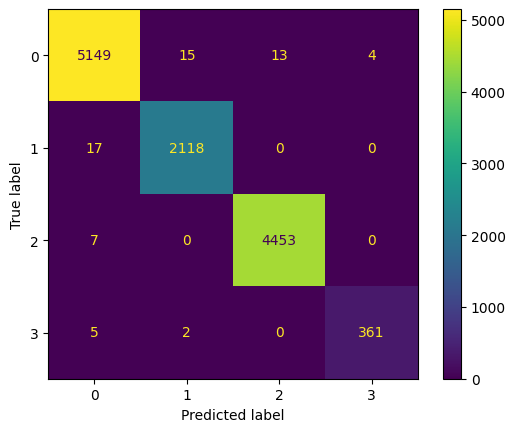

In [12]:
net = torch.load("trained_networks/saved_net_RNA.py").cpu() # load saved network

# calculate predictions for test dataset and compare them to the targets 
X = [i for i,j in test_dataset]
pred = [net(x) for x in X]
y_true = [np.argmax(j) for i,j in test_dataset]
y_pred = [np.argmax(i.detach().numpy()) for i in pred]

acc = accuracy_score(y_true, y_pred)

print(acc)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig("plots/conf_mat_RNA_200.png")
plt.show()

Interpretability

In [8]:
net = torch.load("trained_networks/saved_net_RNA.py").cpu() # load saved network

# perform integrated gradient for each entry of the test dataset
ig = IntegratedGradients(net)
net.eval()
res = np.zeros((4, 200))

for input, target in test_dataset:
    input = input.unsqueeze(0)
    target = torch.argmax(target).unsqueeze(0)
    attributions, delta = ig.attribute(input, target = target, return_convergence_delta=True)
    res[target] += np.array(attributions[0]) # sum up each result for the corresponding target


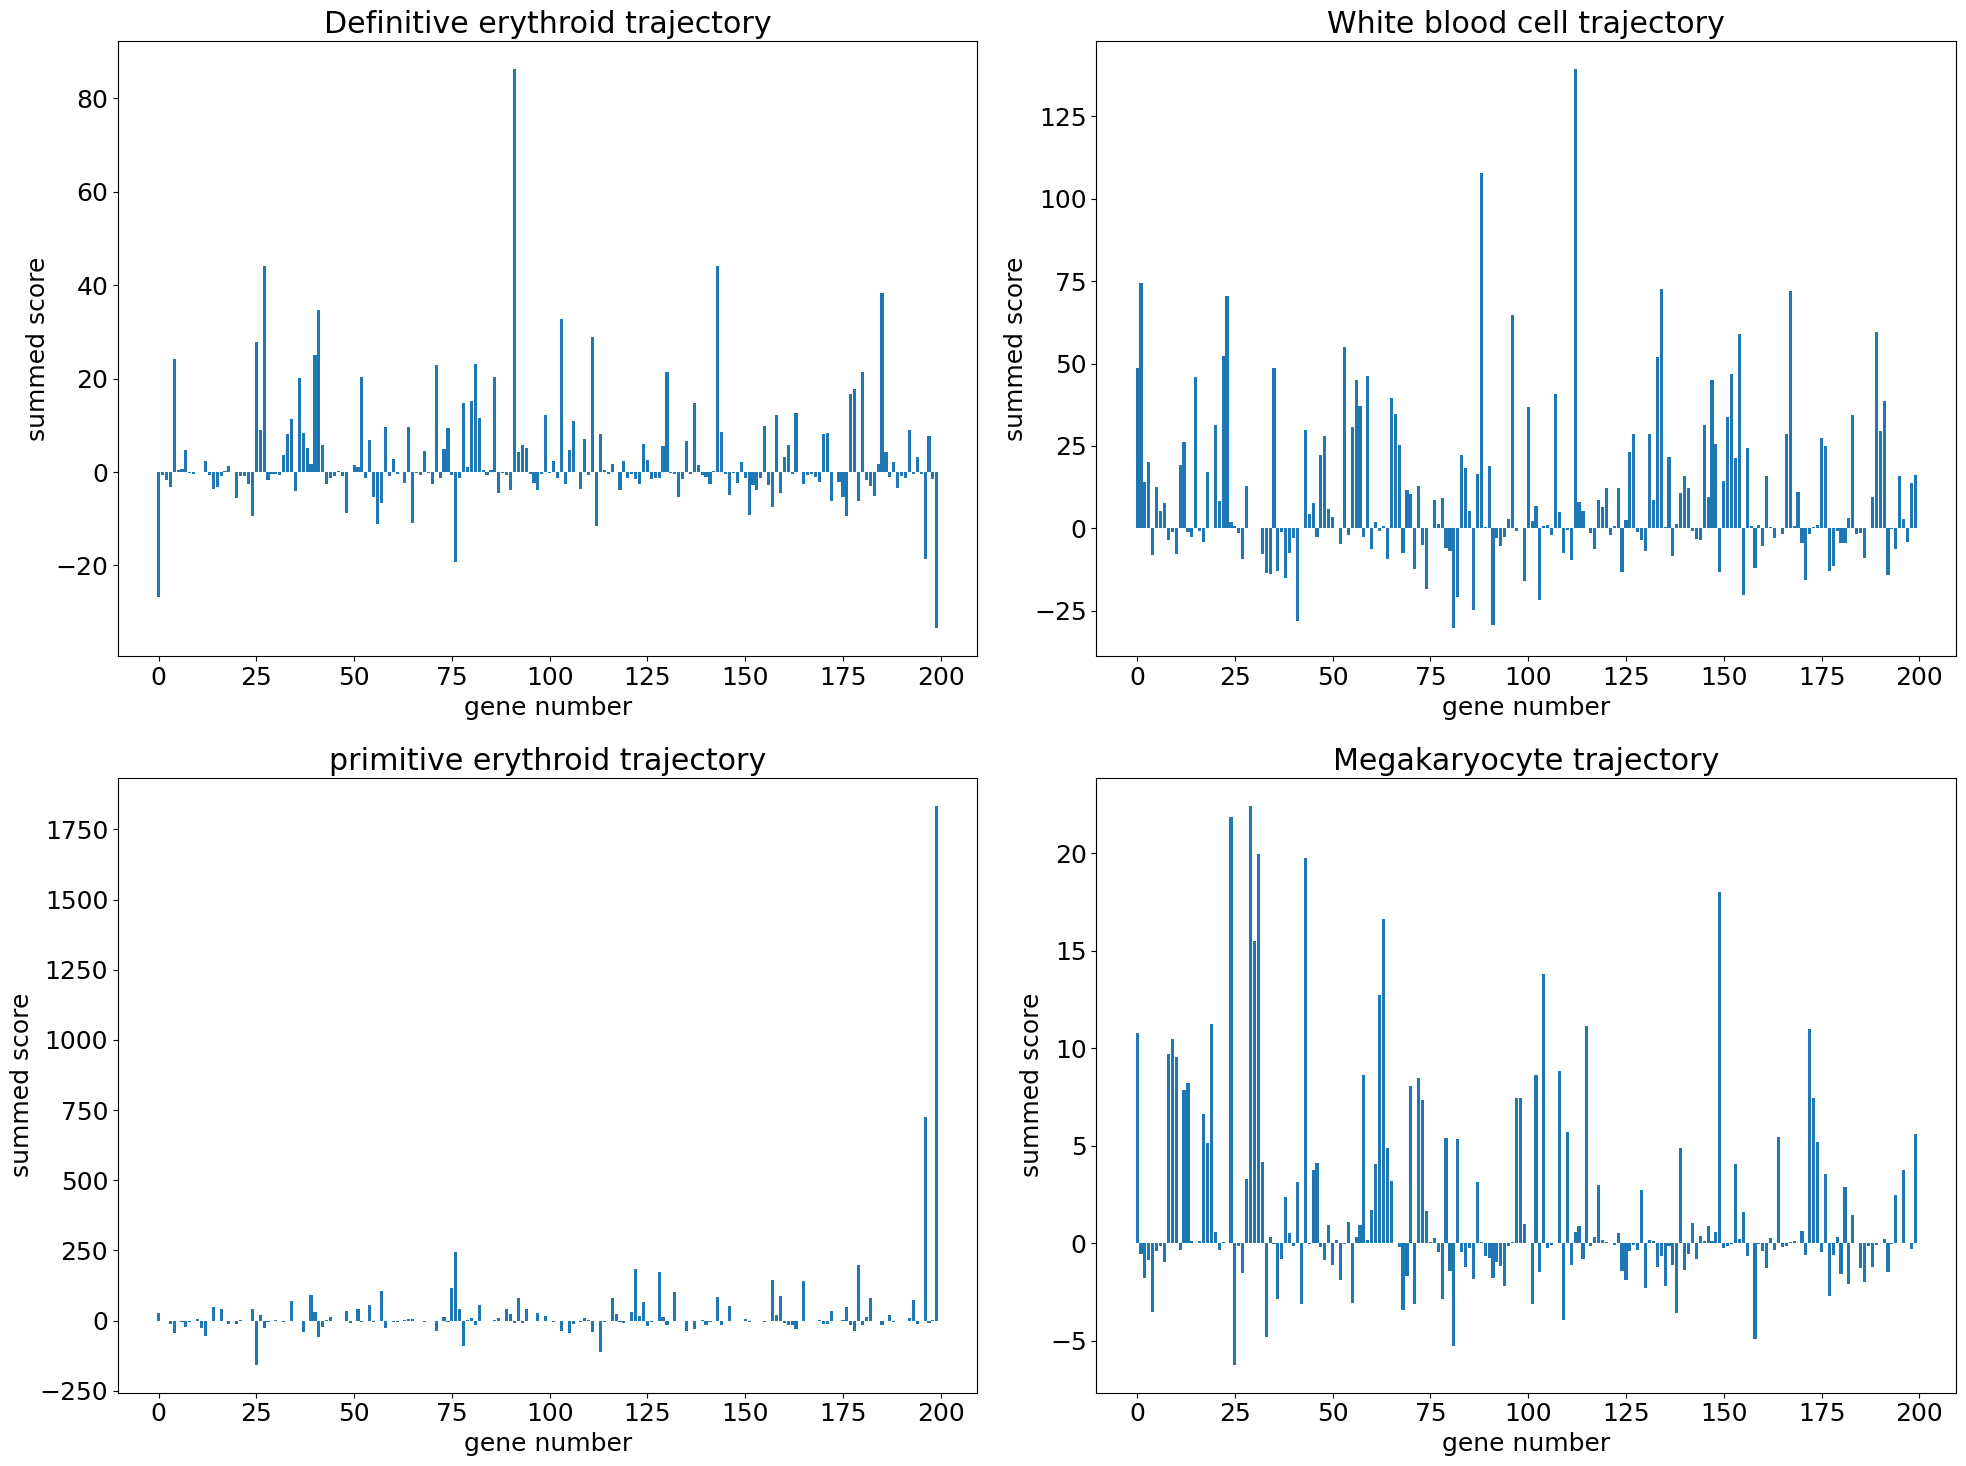

In [10]:
# plot results
plt.figure(figsize=(20,15))
plt.rcParams.update({'font.size': 18})
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(uniques[i])
    plt.xlabel("gene number")
    plt.ylabel("summed score")
    plt.bar(np.arange(200), res[i])

plt.tight_layout()
plt.savefig("attributions_RNA.png")
plt.show()

In [33]:
# calculate the 10 most important genes for each class

top_10 = np.zeros((4, 10))

for i in range(4):
    ind = np.argpartition(res[i], -10)[-10:]
    top_10[i] = ind

top_10 = top_10.astype('int32')

In [34]:
genes = pd.read_csv("../DESeq/genes_by_sig_unique_RNA.csv")
gene_annotations = pd.read_csv("../data/unprocessed/gene_annotate.csv")

important_genes = pd.DataFrame({"gene_id": [],
                               "gene_name": [],
                               "class" : [],
                               "score" : []})

In [35]:
# create a dataframe with the ENSAMBLE id, the short name mapped to it, the corresponding celltype and score
for i in range(4):
    for j in range(10):
        gene_id = genes.loc[top_10[i,j], "gene"]
        gene_name = gene_annotations.loc[gene_annotations["gene_id"] == gene_id, "gene_short_name"].item()
        clas = uniques[i]
        score = res[i, top_10[i,j]]
        important_genes.loc[len(important_genes.index)] = [gene_id, gene_name, clas, score]
        

In [36]:
important_genes.to_csv("important_genes/important_genes_RNA.csv")